<a href="https://colab.research.google.com/github/4stralyn/TEB1093_stat-empirical-method/blob/main/R_stats_final_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#To upload file (runtime -> change runtime type -> runtime type choose python 3 )
from google.colab import files
uploaded = files.upload()

Saving health_fitness_dataset.csv to health_fitness_dataset (1).csv


In [ ]:
library(readr) # (runtime -> change runtime type -> runtime type choose R )

steps <- read_csv("health_fitness_dataset.csv")


Rows: 275602 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): date, day_of_week, gender, activity_type, intensity, smoking_status
dbl (17): participant_id, age, height_cm, weight_kg, bmi, duration_minutes, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PHASE 1 - Data Acquisition and Cleaning

In [ ]:
library(dplyr)
library(lubridate)

# Load the dataset
fitness_data <- read.csv("health_fitness_dataset.csv")

# Convert `date` column to proper Date type (day/month/year)
fitness_data$date <- as.Date(fitness_data$date, format = "%d/%m/%Y")

# Remove duplicate rows if any
fitness_data <- distinct(fitness_data)

# Filter rows with non-missing steps and sleep
fitness_data <- fitness_data %>%
  filter(!is.na(daily_steps), !is.na(sleep_hours))

# Compute average steps per user
user_activity <- fitness_data %>%
  group_by(participant_id) %>%
  summarise(AvgSteps = mean(daily_steps)) %>%
  mutate(ActivityLevel = case_when(
    AvgSteps < 5000 ~ "Sedentary",
    AvgSteps < 10000 ~ "Moderately Active",
    TRUE ~ "Active"
  ))

# Merge classification back into main dataset
merged <- inner_join(fitness_data, user_activity, by = "participant_id")

# Check output
head(merged)
table(user_activity$ActivityLevel)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




,participant_id,date,day_of_week,age,gender,height_cm,weight_kg,bmi,activity_type,duration_minutes,⋯,blood_pressure_systolic,blood_pressure_diastolic,endurance_level,sleep_hours,stress_level,hydration_level,smoking_status,fitness_level,AvgSteps,ActivityLevel
,<int>,<date>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,1,2024-01-01,Monday,56,F,165.3,50.55,18.50,Dancing,42.1,⋯,110.7,72.9,5.37,6.6,4,1.5,Never,0.04,7518.209,Moderately Active
2,1,2024-01-02,Tuesday,56,F,165.3,56.52,20.68,HIIT,28.5,⋯,110.7,72.9,5.86,7.5,6,3.5,Never,1.64,7518.209,Moderately Active
3,1,2024-01-03,Wednesday,56,F,165.3,53.42,19.55,Basketball,86.3,⋯,110.7,72.9,6.42,5.1,8,2.7,Never,3.47,7518.209,Moderately Active
4,1,2024-01-04,Thursday,56,F,165.3,52.53,19.23,Swimming,36.6,⋯,110.7,72.9,7.07,4.8,8,2.3,Never,5.52,7518.209,Moderately Active
5,1,2024-01-05,Friday,56,F,165.3,56.55,20.70,Yoga,27.8,⋯,110.7,72.9,7.72,9.2,4,2.0,Never,7.44,7518.209,Moderately Active
6,1,2024-01-06,Saturday,56,F,165.3,50.55,18.50,Basketball,86.1,⋯,110.7,72.9,8.29,7.2,4,3.1,Never,9.36,7518.209,Moderately Active



           Active Moderately Active         Sedentary 
              639              1635               726 

PHASE 2 - Statistical Analysis

In [ ]:
# TASK A: LARGE-SAMPLE HYPOTHESIS TEST
# H₀ (null): μ = 10,000
# H₁ (alt): μ > 10,000

# Filter only Active users
active_group <- user_activity %>%
  filter(ActivityLevel == "Active")

# Compute values
sample_mean <- mean(active_group$AvgSteps)
sample_sd   <- sd(active_group$AvgSteps)
n           <- nrow(active_group)
mu_0        <- 10000  # hypothesized population mean

# Calculate Z-statistic
z <- (sample_mean - mu_0) / (sample_sd / sqrt(n))

# Calculate one-tailed p-value
p_value <- 1 - pnorm(z)

# Output
cat("===== Task A: Z-Test for Active Users =====\n")
cat("Z-statistic:", z, "\n")
cat("p-value:", p_value, "\n")

# Decision at α = 0.05
if (p_value < 0.05) {
  cat("Conclusion: Reject H₀ because there is significant evidence that Active users exceed 10,000 steps on average (p-value <", 0.05, ").\n")
} else {
  cat("Conclusion: Fail to reject H₀ because there is no significant evidence that Active users exceed 10,000 steps on average (p-value >=", 0.05, ").\n")
}


===== Task A: Z-Test for Active Users =====
Z-statistic: 396.0351 
p-value: 0 
Conclusion: Reject H₀ because there is significant evidence that Active users exceed 10,000 steps on average (p-value < 0.05 ).


In [ ]:
#TASK B: Small-Sample Paired t-Tes

# Label weekdays and weekends
fitness_data$DayType <- ifelse(weekdays(fitness_data$date) %in% c("Saturday", "Sunday"),
                               "Weekend", "Weekday")

# Select 10 users with at least 7 days of data
user_day_counts <- fitness_data %>%
  group_by(participant_id) %>%
  summarise(DayCount = n()) %>%
  filter(DayCount >= 7)

selected_ids <- user_day_counts$participant_id[1:10]

subset_data <- fitness_data %>%
  filter(participant_id %in% selected_ids)

# Compute average steps by DayType (Weekday/Weekend) for each user
weekday_vs_weekend <- subset_data %>%
  group_by(participant_id, DayType) %>%
  summarise(AvgSteps = mean(daily_steps), .groups = "drop") %>%
  tidyr::pivot_wider(names_from = DayType, values_from = AvgSteps)

# Run paired t-test
result <- t.test(weekday_vs_weekend$Weekday, weekday_vs_weekend$Weekend, paired = TRUE)

# Output result
cat("===== TASK B: Small-Sample Paired t-Test =====\n")
cat("t-statistic:", result$statistic, "\n")
cat("p-value:", result$p.value, "\n")
cat("mean difference:", result$estimate, "\n")
cat("95% CI:", result$conf.int[1], "to", result$conf.int[2], "\n")

if (result$p.value < 0.05) {
  cat("Reject H₀: Significant difference in steps between weekdays and weekends (p-value <", 0.05, ").\n")
} else {
  cat("Fail to reject H₀: No significant difference in steps (p-value >=", 0.05, ").\n")
}


===== TASK B: Small-Sample Paired t-Test =====
t-statistic: -2.071396 
p-value: 0.0682096 
mean difference: -240.2914 
95% CI: -502.7119 to 22.12916 
Fail to reject H₀: No significant difference in steps (p-value >= 0.05 ).


In [ ]:
# TASK C: Independent TWO-SAMPLE t-TEST

# 1. Calculate average steps per user and classify ActivityLevel
user_activity <- fitness_data %>%
  group_by(participant_id) %>%
  summarise(AvgSteps = mean(daily_steps, na.rm = TRUE)) %>%
  mutate(ActivityLevel = case_when(
    AvgSteps < 5000 ~ "Sedentary",
    AvgSteps < 10000 ~ "Moderately Active",
    TRUE ~ "Active"
  ))

# 2. Merge back into fitness_data (ONLY ONCE)
fitness_data <- fitness_data %>%
  left_join(user_activity, by = "participant_id")

# 3. Filter only Sedentary & Active
sleep_groups <- fitness_data %>%
  filter(ActivityLevel %in% c("Sedentary", "Active")) %>%
  select(participant_id, ActivityLevel, sleep_hours)

# 4. Split vectors
sedentary <- sleep_groups %>%
  filter(ActivityLevel == "Sedentary") %>%
  pull(sleep_hours)

active <- sleep_groups %>%
  filter(ActivityLevel == "Active") %>%
  pull(sleep_hours)

# 5. Variance check and t-test
var_test <- var.test(sedentary, active)
equal_var <- var_test$p.value > 0.05

t_test_result <- t.test(sedentary, active, var.equal = equal_var)

# 6. Output
cat("===== TASK C: Independent TWO-SAMPLE t-TEST =====\n\n")
cat("F-test for Equal Variances:\n")
cat("F-statistic:", var_test$statistic, "\n")
cat("p-value (F-test):", var_test$p.value, "\n")
cat("Equal variances assumed:", equal_var, "\n\n")

cat("T-test Results:\n")
cat("t-statistic:", t_test_result$statistic, "\n")
cat("p-value:", t_test_result$p.value, "\n")
cat("Mean difference (Sedentary - Active):",
    t_test_result$estimate[1] - t_test_result$estimate[2], "\n")
cat("95% Confidence Interval:", t_test_result$conf.int[1], "to", t_test_result$conf.int[2], "\n\n")

if (t_test_result$p.value < 0.05) {
  cat("Reject H₀: Significant difference in sleep duration.\n")
} else {
  cat("Fail to reject H₀: No significant difference in sleep duration.\n")
}


===== TASK C: Independent TWO-SAMPLE t-TEST =====

F-test for Equal Variances:
F-statistic: 0.9999475 
p-value (F-test): 0.9946324 
Equal variances assumed: TRUE 

T-test Results:
t-statistic: -0.293351 
p-value: 0.7692543 
Mean difference (Sedentary - Active): -0.001614401 
95% Confidence Interval: -0.01240079 to 0.009171989 

Fail to reject H₀: No significant difference in sleep duration.


In [ ]:
# TASK D: ANOVA (ONE-WAY)

# Create Sleep Quality variable (normalized: ideal is 8 hours)
fitness_data <- fitness_data %>%
  mutate(SleepQuality = sleep_hours / 8)

# Run One-Way ANOVA: Does ActivityLevel affect SleepQuality?
anova_result <- aov(SleepQuality ~ ActivityLevel, data = fitness_data)

# Extract ANOVA summary
anova_table <- summary(anova_result)[[1]]
p_value <- anova_table$`Pr(>F)`[1]

# Output
cat("===== TASK D: ANOVA (ONE-WAY) =====\n\n")
cat("===== One-Way ANOVA: Sleep Quality by Activity Level =====\n")
cat(sprintf("%-15s %-8s %-10s %-10s %-10s\n", "Source", "Df", "Sum Sq", "Mean Sq", "F value    Pr(>F)"))

# Row: ActivityLevel
cat(sprintf("%-15s %-8d %-10.4f %-10.4f %-10.2f %-10s\n",
            "ActivityLevel",
            anova_table$Df[1],
            anova_table$`Sum Sq`[1],
            anova_table$`Mean Sq`[1],
            anova_table$`F value`[1],
            format.pval(p_value, digits = 3, eps = .001)))

# Row: Residuals
cat(sprintf("%-15s %-8d %-10.4f %-10.4f\n",
            "Residuals",
            anova_table$Df[2],
            anova_table$`Sum Sq`[2],
            anova_table$`Mean Sq`[2]))

# Conclusion
if (p_value < 0.05) {
  cat("Conclusion: Reject H₀ because there is a significant difference in sleep quality between at least two activity levels (p-value <", 0.05, ").\n")
} else {
  cat("Conclusion: Fail to reject H₀ because there is no significant difference in sleep quality among groups (p-value >=", 0.05, ").\n")
}

# Post-Hoc: Tukey HSD
cat("\n===== Tukey HSD Post-Hoc Test: Sleep Quality Differences =====\n")
tukey_result <- TukeyHSD(anova_result)
print(tukey_result)


===== TASK D: ANOVA (ONE-WAY) =====

===== One-Way ANOVA: Sleep Quality by Activity Level =====
Source          Df       Sum Sq     Mean Sq    F value    Pr(>F)
ActivityLevel   2        0.0576     0.0288     1.95       0.142     
Residuals       275599   4067.2150  0.0148    
Conclusion: Fail to reject H₀ because there is no significant difference in sleep quality among groups (p-value >= 0.05 ).

===== Tukey HSD Post-Hoc Test: Sleep Quality Differences =====
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SleepQuality ~ ActivityLevel, data = fitness_data)

$ActivityLevel
                                     diff           lwr          upr     p adj
Moderately Active-Active     0.0008001548 -0.0005870216 0.0021873313 0.3664753
Sedentary-Active            -0.0002018001 -0.0018144843 0.0014108840 0.9536952
Sedentary-Moderately Active -0.0010019550 -0.0023265368 0.0003226269 0.1787495



PHASE 3 - R Programming Output and Reporting

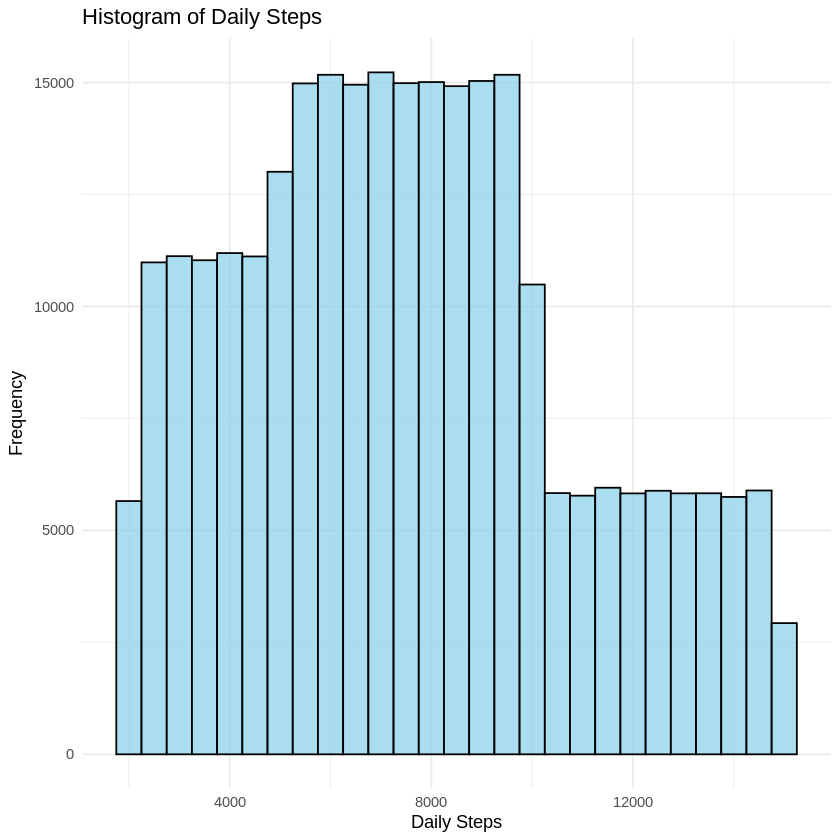

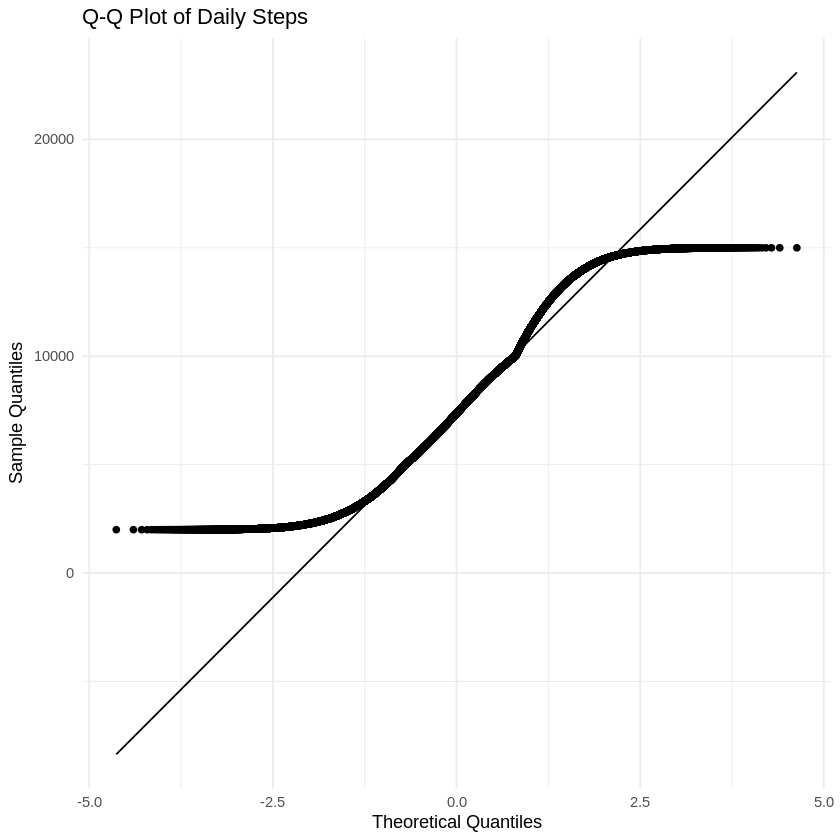

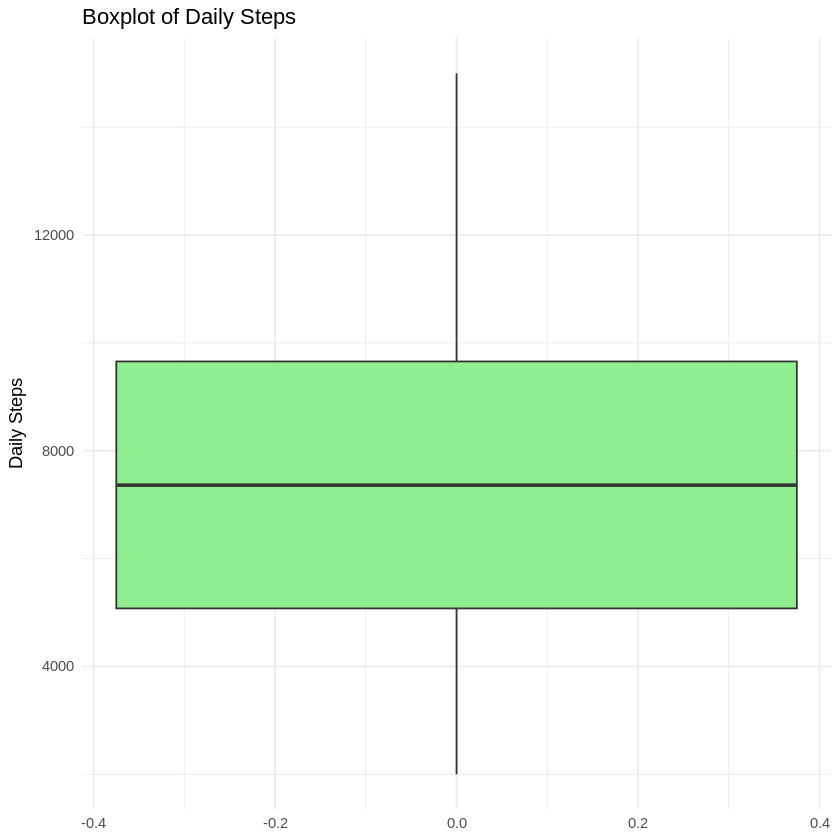

In [ ]:
# Load libraries (skip if already loaded)
library(ggplot2)
library(gridExtra)

# 1. Histogram of Daily Steps
ggplot(fitness_data, aes(x = daily_steps)) +
  geom_histogram(binwidth = 500, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Daily Steps", x = "Daily Steps", y = "Frequency") +
  theme_minimal()

# 2. Q-Q Plot of Daily Steps
ggplot(fitness_data, aes(sample = daily_steps)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "Q-Q Plot of Daily Steps", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()

# 3. Boxplot of Daily Steps
ggplot(fitness_data, aes(y = daily_steps)) +
  geom_boxplot(fill = "lightgreen") +
  labs(title = "Boxplot of Daily Steps", y = "Daily Steps") +
  theme_minimal()


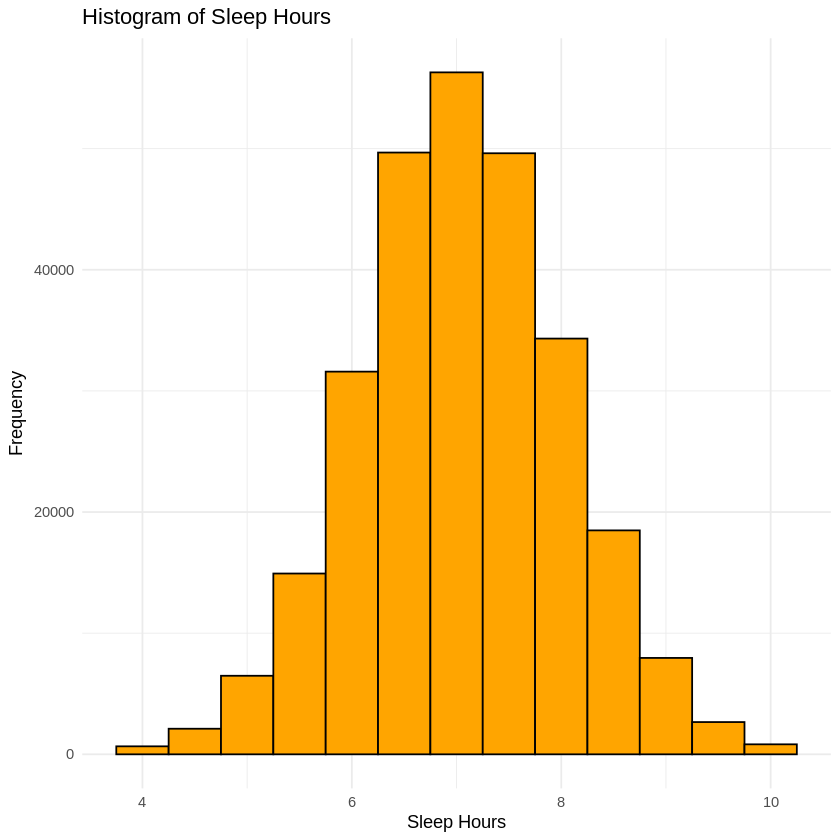

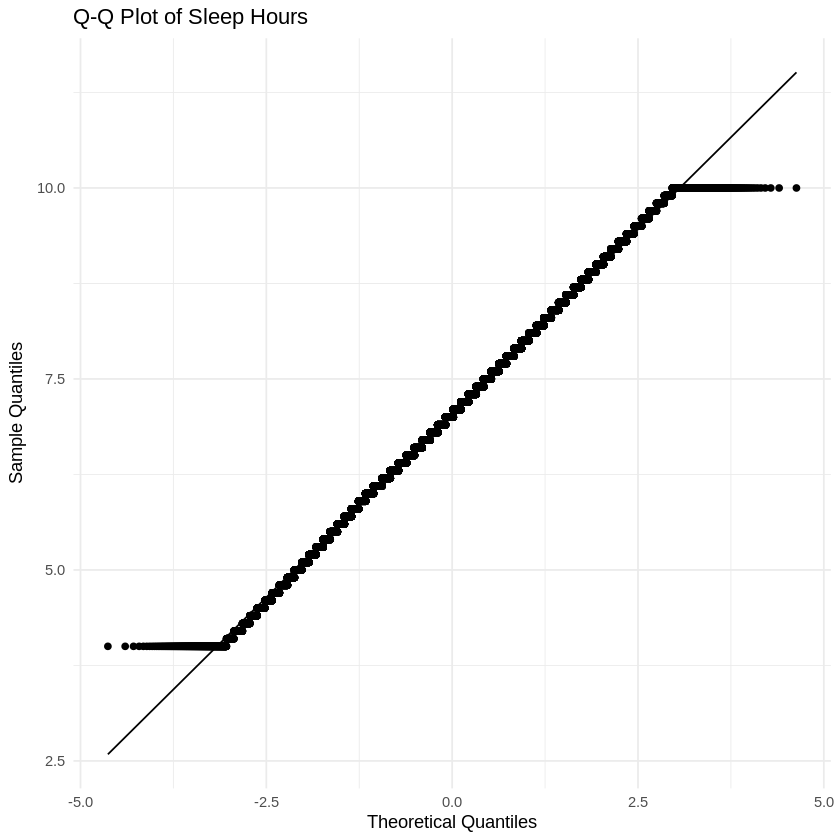

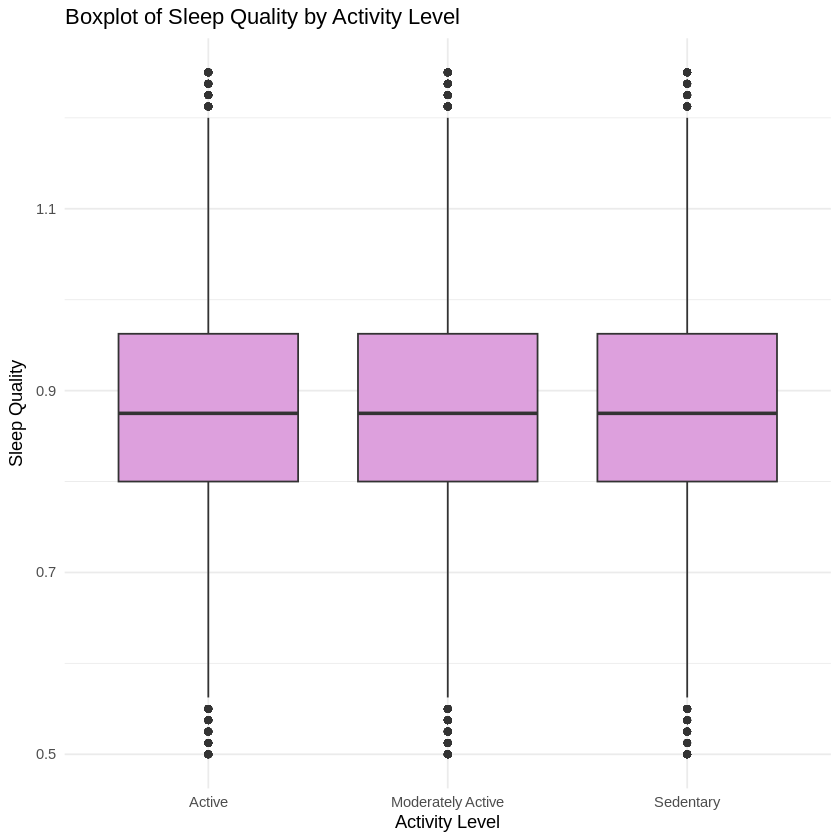

In [ ]:
# Calculate Sleep Quality
fitness_data$SleepQuality <- fitness_data$sleep_hours / 8

# 4. Histogram of Sleep Hours
plot1 <- ggplot(fitness_data, aes(x = sleep_hours)) +
  geom_histogram(binwidth = 0.5, fill = "orange", color = "black") +
  labs(title = "Histogram of Sleep Hours", x = "Sleep Hours", y = "Frequency") +
  theme_minimal()
print(plot1)

# 5. Q-Q Plot of Sleep Hours
plot2 <- ggplot(fitness_data, aes(sample = sleep_hours)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "Q-Q Plot of Sleep Hours", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()
print(plot2)

# 6. Boxplot of Sleep Quality by Activity Level
plot3 <- ggplot(fitness_data, aes(x = ActivityLevel, y = SleepQuality)) +
  geom_boxplot(fill = "plum") +
  labs(title = "Boxplot of Sleep Quality by Activity Level", x = "Activity Level", y = "Sleep Quality") +
  theme_minimal()
print(plot3)
